In [1]:
import pickle

from lmfit.models import GaussianModel
import matplotlib.pyplot as plt
from scipy import ndimage
import numpy as np
import pandas as pd

from mint.snapshot import SnapshotDB

In [2]:
# Reduce originally recorded data to a simple and readable DataFrame of only what I need
snapshot_db = SnapshotDB("original/20210221-01_43_50_scan_phase2.pcl")
tds = snapshot_db.load()

is_beam_on = tds["XFEL.UTIL/BUNCH_PATTERN/CONTROL/BEAM_ALLOWED"].astype("bool")
l1_chirp_phase = tds["XFEL.RF/LLRF.SUMVOLTAGE_CTRL/L1/SUMVOLTAGE.CHIRP.SP.1"]
charge = tds["XFEL.DIAG/CHARGE.ML/TORA.25.I1/CHARGE.ALL"]
tds_image = tds["XFEL.DIAG/CAMERA/OTRA.473.B2D/IMAGE_EXT_ZMQ"].apply(lambda path: pickle.load(open("original/"+path[2:-4]+".pcl", "rb")))

tds_reduced = pd.DataFrame({"is_beam_on": is_beam_on,
                            "l1_chirp_phase": l1_chirp_phase,
                            "charge": charge,
                            "tds_image": tds_image})
tds_reduced

,is_beam_on,l1_chirp_phase,charge,tds_image
0,True,-7.0,0.25550,"[[21, 0, 0, 0, 38, 0, 0, 10, 0, 0, 3, 0, 11, 0..."
1,False,-7.0,NaN,"[[9, 0, 5, 0, 0, 11, 0, 0, 14, 6, 12, 14, 0, 0..."
2,False,-7.0,NaN,"[[0, 0, 12, 0, 15, 0, 10, 2, 14, 0, 10, 0, 0, ..."
3,False,-7.0,NaN,"[[0, 0, 1, 13, 0, 0, 0, 0, 21, 0, 0, 0, 0, 0, ..."
4,False,-7.0,NaN,"[[0, 4, 0, 25, 0, 5, 0, 13, 0, 0, 22, 0, 0, 0,..."
...,...,...,...,...
191,True,5.0,0.25205,"[[0, 0, 0, 0, 7, 0, 0, 15, 1, 0, 24, 0, 3, 0, ..."
192,True,5.0,0.25000,"[[0, 10, 13, 3, 0, 0, 11, 0, 0, 0, 13, 0, 20, ..."
193,True,5.0,0.24610,"[[13, 1, 0, 0, 17, 0, 0, 0, 0, 0, 0, 21, 0, 20..."
194,True,5.0,0.24920,"[[0, 0, 0, 0, 0, 0, 0, 0, 13, 11, 4, 4, 0, 0, ..."


In [3]:
background = tds_reduced.loc[1:6,"tds_image"].mean()

preprocessed = tds_reduced.loc[6:,["l1_chirp_phase","charge","tds_image"]].copy()

# Average all five images per chirp setting
preprocessed = preprocessed.groupby("l1_chirp_phase").apply(np.mean).drop("l1_chirp_phase", axis=1)
preprocessed["tds_image"] = preprocessed["tds_image"].apply(lambda image: image.clip(0, 4095))

# Remove background
remove_background = lambda image: (image - background).clip(0, 4095)
preprocessed["tds_image"] = preprocessed["tds_image"].apply(remove_background)

# Denoise images
def denoise(image):
    denoised = ndimage.uniform_filter(image, size=12)
    denoised[denoised < 0.05 * denoised.max()] = 0
    return denoised

preprocessed["tds_image"] = preprocessed["tds_image"].apply(denoise)

# Extract current profiles
def extract_current_profile(row):
    seconds_per_pixel = 0.0438912 * 10e-12

    view = row["tds_image"].sum(axis=0)
    current = row["charge"] * 10e-9 / seconds_per_pixel * view / view.sum()

    xs = np.arange(len(current))
    model = GaussianModel()
    guess = model.guess(current, x=xs)
    fit = model.fit(current, guess, x=xs)

    low = int(fit.params["center"].value - 4 * fit.params["sigma"].value)
    high = int(fit.params["center"].value + 4 * fit.params["sigma"].value)
    extracted = current[low:high]

    return extracted

preprocessed = preprocessed.apply(extract_current_profile, axis=1)
preprocessed

l1_chirp_phase
-12.0    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
-11.5    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
-11.0    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
-10.5    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
-10.0    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
-9.5     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
-9.0     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
-8.5     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
-8.0     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
-7.5     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
-7.0     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
-6.0     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
-5.0     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
-3.0     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
-1.0     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
 2.0     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
 5.0     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

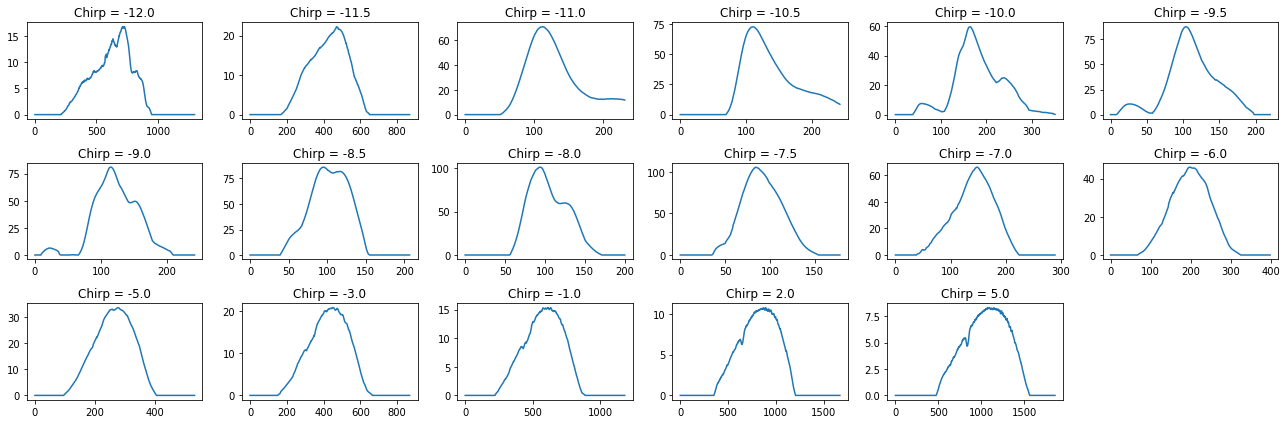

In [4]:
plt.figure(figsize=(18,6))
for i, chirp in enumerate(preprocessed.index.values):
    plt.subplot(3, 6, i+1)
    plt.title(f"Chirp = {chirp}")
    plt.plot(preprocessed[chirp])
plt.tight_layout()
plt.show()

In [5]:
with open("profiles_feb_phase2.pkl", "wb") as file:
    pickle.dump(preprocessed, file)